In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.autograd import Variable, grad
from utils import create_dataloader
from torch.utils.data import Dataset, DataLoader

from skimage import io
import numpy as np
from os import listdir
from os.path import isfile, join

%matplotlib inline

In [2]:
def get_noise(bs=16, noise_size=50):
    return Variable(torch.FloatTensor(bs, noise_size).normal_(0, 1), requires_grad=False)

In [3]:
class DataAcc:
    def __init__(self, dataloader):
        self.dl = dataloader
        self.it = iter(self.dl)
    
    def get_next(self):
        res = None
        try:
            res = next(self.it)
        except:
            self.it = iter(self.dl)
            res = next(self.it)
        return res

# data_acc = DataAcc(dataloader)

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = '../data/mnist'
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100

### Create dataloder

In [3]:
dataloader = create_dataloader(config)

In [4]:
len(dataloader)

3750

In [5]:
for image, cat in dataloader:
    break

In [6]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [8]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

### Create optimizers and loss

In [9]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

### Create necessary variables

In [10]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Имплементируйте GAN из статьи

2) Попробуйте LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Попробуйте оба GAN на CelebA http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

Обязательны графики.

### Main loop

#### GAN on MNIST

In [14]:
criterion = nn.BCELoss()
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cuda()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errD_x = loss.data[0]
        
        # fake
        fake_images = generator(get_noise().cuda()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
        loss.backward()
        errD_z = loss.data[0]
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cuda())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errG = loss.data[0]
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x,
                                                                                            errD_z, 
                                                                                            errG))
    

Epoch:1 Iter: 100 errD_x: 0.12 errD_z: 0.03 errG: 5.29
Epoch:1 Iter: 200 errD_x: 0.06 errD_z: 0.04 errG: 3.70
Epoch:1 Iter: 300 errD_x: 0.09 errD_z: 0.02 errG: 5.23
Epoch:1 Iter: 400 errD_x: 0.18 errD_z: 0.01 errG: 4.11
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.12 errG: 3.61
Epoch:1 Iter: 600 errD_x: 0.23 errD_z: 0.06 errG: 3.57
Epoch:1 Iter: 700 errD_x: 0.05 errD_z: 0.01 errG: 4.58
Epoch:1 Iter: 800 errD_x: 0.38 errD_z: 0.06 errG: 5.23
Epoch:1 Iter: 900 errD_x: 0.17 errD_z: 0.09 errG: 2.89
Epoch:1 Iter: 1000 errD_x: 0.02 errD_z: 0.10 errG: 4.28
Epoch:1 Iter: 1100 errD_x: 0.49 errD_z: 0.04 errG: 4.84
Epoch:1 Iter: 1200 errD_x: 0.02 errD_z: 0.09 errG: 4.14
Epoch:1 Iter: 1300 errD_x: 0.02 errD_z: 0.18 errG: 3.21
Epoch:1 Iter: 1400 errD_x: 0.02 errD_z: 0.06 errG: 3.94
Epoch:1 Iter: 1500 errD_x: 0.41 errD_z: 0.02 errG: 4.58
Epoch:1 Iter: 1600 errD_x: 0.00 errD_z: 0.06 errG: 3.48
Epoch:1 Iter: 1700 errD_x: 0.03 errD_z: 0.39 errG: 3.50
Epoch:1 Iter: 1800 errD_x: 0.01 errD_z: 0.13 errG: 3.88
E

Epoch:4 Iter: 3700 errD_x: 0.11 errD_z: 0.06 errG: 3.37
Epoch:5 Iter: 100 errD_x: 0.06 errD_z: 0.06 errG: 3.90
Epoch:5 Iter: 200 errD_x: 0.15 errD_z: 0.07 errG: 3.88
Epoch:5 Iter: 300 errD_x: 0.02 errD_z: 0.10 errG: 3.56
Epoch:5 Iter: 400 errD_x: 0.11 errD_z: 0.10 errG: 2.53
Epoch:5 Iter: 500 errD_x: 0.48 errD_z: 0.12 errG: 4.63
Epoch:5 Iter: 600 errD_x: 0.25 errD_z: 0.03 errG: 4.44
Epoch:5 Iter: 700 errD_x: 0.11 errD_z: 0.03 errG: 3.79
Epoch:5 Iter: 800 errD_x: 0.08 errD_z: 0.03 errG: 4.29
Epoch:5 Iter: 900 errD_x: 0.05 errD_z: 0.02 errG: 3.79
Epoch:5 Iter: 1000 errD_x: 0.01 errD_z: 0.02 errG: 3.87
Epoch:5 Iter: 1100 errD_x: 0.00 errD_z: 0.05 errG: 5.02
Epoch:5 Iter: 1200 errD_x: 0.23 errD_z: 0.04 errG: 2.45
Epoch:5 Iter: 1300 errD_x: 0.00 errD_z: 0.08 errG: 4.50
Epoch:5 Iter: 1400 errD_x: 0.20 errD_z: 0.10 errG: 3.43
Epoch:5 Iter: 1500 errD_x: 0.01 errD_z: 0.12 errG: 4.44
Epoch:5 Iter: 1600 errD_x: 0.28 errD_z: 0.05 errG: 4.56
Epoch:5 Iter: 1700 errD_x: 0.02 errD_z: 0.08 errG: 3.51
E

Epoch:8 Iter: 3600 errD_x: 0.00 errD_z: 0.04 errG: 2.97
Epoch:8 Iter: 3700 errD_x: 0.05 errD_z: 0.04 errG: 2.64
Epoch:9 Iter: 100 errD_x: 0.03 errD_z: 0.08 errG: 2.87
Epoch:9 Iter: 200 errD_x: 0.25 errD_z: 0.05 errG: 4.02
Epoch:9 Iter: 300 errD_x: 0.43 errD_z: 0.09 errG: 3.00
Epoch:9 Iter: 400 errD_x: 0.08 errD_z: 0.13 errG: 3.03
Epoch:9 Iter: 500 errD_x: 0.26 errD_z: 0.18 errG: 3.12
Epoch:9 Iter: 600 errD_x: 0.04 errD_z: 0.11 errG: 2.99
Epoch:9 Iter: 700 errD_x: 0.16 errD_z: 0.10 errG: 3.67
Epoch:9 Iter: 800 errD_x: 0.21 errD_z: 0.12 errG: 3.11
Epoch:9 Iter: 900 errD_x: 0.16 errD_z: 0.10 errG: 3.59
Epoch:9 Iter: 1000 errD_x: 0.05 errD_z: 0.12 errG: 3.78
Epoch:9 Iter: 1100 errD_x: 0.07 errD_z: 0.21 errG: 3.22
Epoch:9 Iter: 1200 errD_x: 0.36 errD_z: 0.05 errG: 3.21
Epoch:9 Iter: 1300 errD_x: 0.08 errD_z: 0.19 errG: 3.37
Epoch:9 Iter: 1400 errD_x: 0.29 errD_z: 0.25 errG: 3.57
Epoch:9 Iter: 1500 errD_x: 0.22 errD_z: 0.05 errG: 4.29
Epoch:9 Iter: 1600 errD_x: 0.28 errD_z: 0.10 errG: 4.38
E

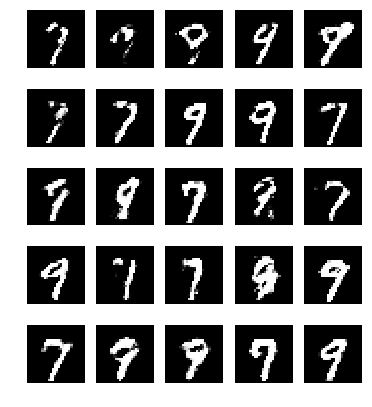

In [15]:
X = generator(get_noise(25).cuda()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

#### LSGAN on MNIST

In [20]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

optim_G = optim.Adam(params=generator.parameters(), lr=0.00004)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.00003)

In [23]:
len(dataloader)

3750

How to train?

First we run 1 iter of D train to 5 iter of G train for 10k iter

Then we run 1 iter of D to 1 iter of G for 3-6k iter

Finally we run 3 iter of D to 1 iter of G for 2k iter

In [45]:
criterion = nn.MSELoss()
for iteration in range(3000):
    errD_x = 0
    errD_z = 0
    errG = 0
    for _ in range(3):
        ####### 
        # Discriminator stage: minimize (D(x) - 1)^2 + (D(G(z)))^2
        #######
        discriminator.zero_grad()
        images, _ = data_acc.get_next()
        # real
        images = Variable(images, requires_grad=False).view(-1, 784).cuda()
        loss = criterion(discriminator(images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errD_x = loss.data[0]
        
        # fake
        fake_images = generator(get_noise().cuda()).detach()
        loss = criterion(discriminator(fake_images), Variable(torch.zeros(config.batch_size, 1)).cuda())
        loss.backward()
        errD_z = loss.data[0]
        
        optim_D.step()
        
    for _ in range(1):
        ####### 
        # Generator stage: minmize (D(G(x) - 1)^2
        #######
        generator.zero_grad()
        
        fake_images = generator(get_noise().cuda())
        loss = criterion(discriminator(fake_images), Variable(torch.ones(config.batch_size, 1)).cuda())
        loss.backward()
        errG = loss.data[0]
        
        optim_G.step()
        
    if (iteration+1) % 100 == 0:
        print('Iter:{} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(iteration+1,
                                                                                    errD_x,
                                                                                    errD_z, 
                                                                                    errG))

Iter:100 errD_x: 0.03 errD_z: 0.01 errG: 0.83
Iter:200 errD_x: 0.02 errD_z: 0.02 errG: 0.69
Iter:300 errD_x: 0.06 errD_z: 0.05 errG: 0.72
Iter:400 errD_x: 0.04 errD_z: 0.03 errG: 0.77
Iter:500 errD_x: 0.01 errD_z: 0.03 errG: 0.81
Iter:600 errD_x: 0.06 errD_z: 0.01 errG: 0.84
Iter:700 errD_x: 0.02 errD_z: 0.02 errG: 0.81
Iter:800 errD_x: 0.04 errD_z: 0.02 errG: 0.83
Iter:900 errD_x: 0.01 errD_z: 0.07 errG: 0.69
Iter:1000 errD_x: 0.02 errD_z: 0.02 errG: 0.85
Iter:1100 errD_x: 0.04 errD_z: 0.02 errG: 0.75
Iter:1200 errD_x: 0.00 errD_z: 0.01 errG: 0.87
Iter:1300 errD_x: 0.03 errD_z: 0.03 errG: 0.76
Iter:1400 errD_x: 0.01 errD_z: 0.01 errG: 0.84
Iter:1500 errD_x: 0.04 errD_z: 0.02 errG: 0.89
Iter:1600 errD_x: 0.01 errD_z: 0.02 errG: 0.87
Iter:1700 errD_x: 0.02 errD_z: 0.02 errG: 0.83
Iter:1800 errD_x: 0.01 errD_z: 0.03 errG: 0.81
Iter:1900 errD_x: 0.01 errD_z: 0.01 errG: 0.86
Iter:2000 errD_x: 0.01 errD_z: 0.01 errG: 0.91
Iter:2100 errD_x: 0.01 errD_z: 0.01 errG: 0.86
Iter:2200 errD_x: 0.02

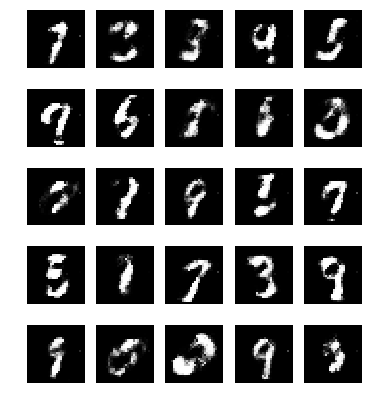

In [46]:
X = generator(get_noise(25).cuda()).data.cpu().numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

## Progressive Growing of GANs for Improved Quality, Stability, and Variation
http://research.nvidia.com/publication/2017-10_Progressive-Growing-of

In [4]:
class Config:
    pass

config = Config()
config.noise_size = 384
config.batch_size = 16

In [5]:
resolution = 128
R = int(np.log2(resolution))
assert resolution == 2**R and resolution >= 4
R

7

In [6]:
def show(X, bs, figsize=(15, 15), square=False):
    nrows, ncols = 1, bs
    if square:
        side = int(np.sqrt(bs))
        assert side * side == bs
        nrows, ncols = side, side
    X = X.data.permute(0, 2, 3, 1).cpu().numpy()
    plt.figure(figsize=figsize)
    for i in range(bs):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(X[i])
        plt.axis('off')
    plt.show()

def generate_demo(g, R, bs, ns, alpha=None):
    imsize = 2**R
    g.eval()
    X = g(get_noise(bs, ns).cuda(), R, alpha).data.permute(0, 2, 3, 1).cpu().numpy()
    g.train()
    plt.figure(figsize=(15, 7))
    for i in range(bs):
        plt.subplot(1, bs, i+1)
        plt.imshow(X[i].reshape(imsize, imsize, 3))
        plt.axis('off')
    plt.show()

In [7]:
class LRN(nn.Module):
    def __init__(self, eps=1e-8):
        super(LRN, self).__init__()
        self.eps = eps

    def forward(self, x):
        x2 = x**2
        norm = torch.sum(x2, 1, keepdim=True)
        return x / torch.sqrt(norm + self.eps)

In [8]:
img_root = '../img_align_celeba'
imgs = sorted([f for f in listdir(img_root) if isfile(join(img_root, f))])

In [9]:
class CelebA(Dataset):
    def __init__(self, imgs_path, imgs):
        self.imgs_path = imgs_path
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_name = join(self.imgs_path, self.imgs[idx])
        image = io.imread(img_name)

        return image[45:173, 25:153] / 256.0

In [10]:
celeba_dataset = CelebA(img_root, imgs)
celeba_dataloader = DataLoader(celeba_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
data_acc = DataAcc(celeba_dataloader)

In [11]:
def he_init(w):
    nn.init.kaiming_normal(w)
    
class WSConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(WSConv2d, self).__init__(in_channels, out_channels,
                                       kernel_size, stride=stride,
                                       padding=padding)
#         self.weight.data.normal_()
        he_init(self.weight.data) # TODO: find out how its works
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2))
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSConv2d, self).forward(x)
    
class WSLinear(nn.Linear):
    def __init__(self, in_features, out_features):
        super(WSLinear, self).__init__(in_features, out_features)
#         self.weight.data.normal_()
        he_init(self.weight.data)
        w = self.weight.data
        self.scale = np.sqrt(torch.mean(w ** 2))
        self.weight.data *= 1 / self.scale

    def forward(self, x):
        x = x * self.scale
        return super(WSLinear, self).forward(x)



class Generator(nn.Module):
    def __init__(self, noise_size):
        super(Generator, self).__init__()
        self.noise_size = noise_size
        
        self.first_block = nn.Sequential(
            WSConv2d(self.noise_size, self.noise_size, 4, stride=1, padding=3),
            nn.LeakyReLU(0.2),
            LRN(),
            WSConv2d(self.noise_size, self.noise_size, 3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            LRN()
        )
        
        size = self.noise_size
        iter_blocks = [None] * 5
        to_rgb = [None] * 6
        to_rgb[0] = WSConv2d(size, 3, 1, stride=1, padding=0)
        for i in range(5):
            new_size = size // 2 if i > 3 else size
            
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN(),
                WSConv2d(new_size, new_size, 3, stride=1, padding=1),
                nn.LeakyReLU(0.2),
                LRN()
            )
            to_rgb[i + 1] = WSConv2d(new_size, 3, 1, stride=1, padding=0)
            size = new_size
            
        self.to_rgb = nn.ModuleList(to_rgb)
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        
    def forward(self, x, R, alpha=None):
        x /= torch.sqrt(torch.sum(x**2, 1, keepdim=True))
        x = x.view(-1, self.noise_size, 1, 1)
        x = self.first_block(x)
        x_from_old = None
        for i in range(R - 2):
            x = nn.Upsample(scale_factor=2)(x)
            
            if (alpha is not None) and (i == R - 3):
                x_from_old = self.to_rgb[R - 3](x)
                
            x = self.iter_blocks[i](x)
            
        if alpha is not None:
            x = self.to_rgb[R - 2](x) * alpha + x_from_old * (1 - alpha)
        else:
            x = self.to_rgb[R - 2](x)
        return x
    
    
class Discriminator(nn.Module):
    def __init__(self, noise_size):
        super(Discriminator, self).__init__()
        self.noise_size = noise_size
        
        from_rgb = [None] * 6
        for R in range(2, 8):
            size = self.noise_size // 2**(R-5) if R > 5 else self.noise_size
            from_rgb[R - 2] = nn.Sequential(
                WSConv2d(3, size, 1), 
                nn.LeakyReLU(0.2))
        self.from_rgb = nn.ModuleList(from_rgb)
        
        size = self.noise_size // 2**2
        iter_blocks = [None] * 5
        for i in range(0, 5):
            new_size = size * 2 if i < 2 else size
            
            iter_blocks[i] = nn.Sequential(
                WSConv2d(size, size, 3, padding=1),
                nn.LeakyReLU(0.2),
                WSConv2d(size, new_size, 3, padding=1),
                nn.LeakyReLU(0.2),
                nn.AvgPool2d(2))
            
            size = new_size
        self.iter_blocks = nn.ModuleList(iter_blocks)
        
        self.final_conv = nn.Sequential(
            WSConv2d(self.noise_size+1, self.noise_size, 3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(self.noise_size, self.noise_size, 4),
            nn.LeakyReLU(0.2))
        
        self.pred = WSLinear(self.noise_size, 1)
        
    def forward(self, x, R, alpha=None):
        minibatch_std = torch.mean(torch.std(x, 0))
#         minibatch_std = 0
        x_from_old = None
        if alpha is not None:
            x_from_old = self.from_rgb[R - 3](nn.AvgPool2d(2)(x))
            
        x = self.from_rgb[R - 2](x)
        
        for i in range(7 - R, 5):
            x = self.iter_blocks[i](x)
            if (alpha is not None) and (i == 7 - R):
                x = x * alpha + x_from_old * (1 - alpha)
        minibatch_std = Variable(torch.Tensor(x.size(0), 1, 4, 4).cuda().fill_(1.0)) * minibatch_std
        x = torch.cat([x, minibatch_std], 1)
        x = self.final_conv(x)
        x = x.view(-1, self.noise_size)
        x = self.pred(x)
        return x

In [12]:
def avergage_generator(gen, gen_av, decay=0.999):
    source_params = list(gen.parameters())
    av_params = list(gen_av.parameters())
    for i in range(len(av_params)):
        av_params[i].data *= decay
        av_params[i].data += (1.0 - decay) * source_params[i].data.cpu()

In [13]:
def save_checkpoint(state, path='checkpoints/', verbose=True):
    filename = path + str(state['R']) + '_' + str(state['stage']) + '_' + str(state['n_iter']) + '.pth.tar'
    if verbose:
        print('Saved checkpoint: ' + filename)
    torch.save(state, filename)

In [14]:
def gen_loss(g, d, gen_noise, R, alpha):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, R, alpha)
    
    # feed data through discriminator
    disc_out = d(gen_data, R, alpha)
    
    # get loss
    loss = -disc_out.mean()
    
    return loss

def dis_loss(g, d, gen_noise, real_data, R, alpha, gp_alpha, lmb, iwass_epsilon=0.001):
    # draw noise
    gen_noise.data.normal_()
    
    # get generated data
    gen_data = g(gen_noise, R, alpha)
    
    # feed data through discriminator
    disc_out_gen = d(gen_data, R, alpha)
    disc_out_real = d(real_data, R, alpha)
    
    # get loss (w/o GP)
    loss = disc_out_gen.mean() - disc_out_real.mean()
    
    # draw interpolation values
    gp_alpha.uniform_()
    
    # interpolate between real and generated data
    interpolates = gp_alpha * real_data.data + (1 - gp_alpha) * gen_data.data
    interpolates = Variable(interpolates, requires_grad=True)
    
    # feed interpolates through discriminator
    disc_out_interp = d(interpolates, R, alpha)
    
    # get gradients of discriminator output with respect to input
    gradients = grad(outputs=disc_out_interp.sum(), inputs=interpolates,
                     create_graph=True)[0]
    
    # calculate gradient penalty
    grad_pen = ((gradients.view(gradients.size(0), -1).norm(2, dim=1) - 1)**2).mean()
    
    # add gradient penalty to loss
    loss += lmb * grad_pen
    
    # additional penalty term to keep the scores from drifting too far from zero
    loss += (disc_out_real ** 2).mean() * iwass_epsilon
    
    return loss

def train_discriminator(g, d, opt_d, gen_noise, gp_alpha, R, alpha=None):
    d.zero_grad()
    
#     images = torch.from_numpy(celeba_dataset[0].reshape(1, 128, 128, 3))
#     images = images.repeat(config.batch_size, 1, 1, 1)
    images = data_acc.get_next()
    images = images * 2 - 1
    images = Variable(images, requires_grad=False).permute(0, 3, 1, 2).float().cuda()
    images = nn.AvgPool2d(2**(7 - R))(images)
    
    loss = dis_loss(g, d, gen_noise, images, R, alpha, gp_alpha, 10.0)
    loss.backward()
        
    opt_d.step()
    
    return loss.data.cpu().numpy()[0]

def train_generator(g, d, opt_g, gen_noise, R, alpha=None):
    g.zero_grad()
    
    loss = gen_loss(g, d, gen_noise, R, alpha)
    loss.backward()
        
    opt_g.step()
    
    return loss.data.cpu().numpy()[0]

In [15]:
generator = Generator(config.noise_size).cuda()
generator_av = Generator(config.noise_size)
discriminator = Discriminator(config.noise_size).cuda()

optim_G = optim.Adam(params=generator.parameters(), lr=0.001, betas=(0, 0.99))
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.001, betas=(0, 0.99))

NOISE = get_noise(config.batch_size, config.noise_size).cuda()
GP_ALPHA = torch.Tensor(config.batch_size, 1, 1, 1).cuda()

In [16]:
R = 2
max_R = 7
stage = 1
n_iter = 35000
print_every = 1000

In [17]:
checkpoint_path = 'checkpoints/6_0_24000.pth.tar'
# checkpoint_path = 'checkpoints/4_0_20.pth.tar'

checkpoint = torch.load(checkpoint_path)
R = checkpoint['R']
stage = checkpoint['stage']

generator.load_state_dict(checkpoint['gen'])
discriminator.load_state_dict(checkpoint['dis'])

optim_G.load_state_dict(checkpoint['optim_G'])
optim_D.load_state_dict(checkpoint['optim_D'])
            
n_iter = checkpoint['n_iter']
print_every = checkpoint['print_every']
max_R = checkpoint['max_R']
print('R: ' + str(R))
print('stage: ' + str(stage))
print('n_iter: ' + str(n_iter))
print('print_every: ' + str(print_every))
print('max_R: ' + str(max_R))

start_from = 0

R: 6
stage: 0
n_iter: 24000
print_every: 1000
max_R: 7


In [23]:
print_every = 1000

In [24]:
start_from = 1400

Saved checkpoint: debug/2000_6_0_27000.pth.tar
FADE-IN. Iter:2000 errD: -2.24 errG: 16.61


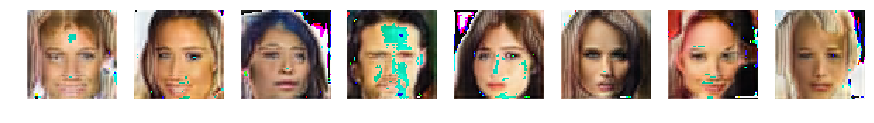

Saved checkpoint: debug/3000_6_0_27000.pth.tar
FADE-IN. Iter:3000 errD: -1.83 errG: 17.59


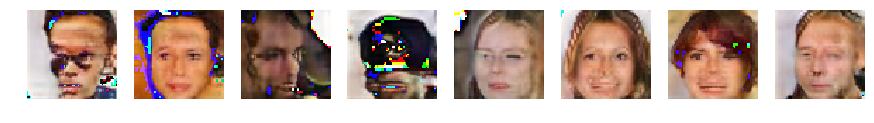

KeyboardInterrupt: 

In [25]:
# discriminator.train()
# generator.train()

for Rr in range(2, 8):
    l = torch.mean(generator(NOISE, Rr)) * 1e-20
    l.backward()
    optim_G.step()
    l = torch.mean(discriminator(generator(NOISE, Rr), Rr)) * 1e-20
    l.backward()
    optim_D.step()

stage_to_str = ['FADE-IN', 'STAB']

while R <= max_R:
    n_iter = 15000 + (R - 2) * 3000
    for iteration in range(start_from, n_iter):
        alpha = (iteration / n_iter) if stage == 0 else None
        
        errD = train_discriminator(generator, discriminator, optim_D,
                        NOISE, GP_ALPHA, R, alpha)
    
        errG = train_generator(generator, discriminator, optim_G,
                    NOISE, R, alpha)
        
#         avergage_generator(generator, generator_av)
    
        if iteration % print_every == 0:
            save_checkpoint({
                'R': R,
                'stage': stage,
                'gen': generator.state_dict(),
                'dis': discriminator.state_dict(),
                'optim_G': optim_G.state_dict(),
                'optim_D': optim_D.state_dict(),
                'n_iter': n_iter,
                'print_every': print_every,
                'max_R': max_R
            }, path='debug/' + str(iteration) + '_')
            NOISE.data.normal_()
            print(stage_to_str[stage] + '. Iter:{} errD: {:.2f} errG: {:.2f}'.format(iteration, errD, errG))
            show((generator(NOISE, R, alpha) + 1) / 2, 8)
#             show((generator_av(NOISE.cpu(), R, alpha) + 1) / 2, 8)
    R += stage
    stage = 1 - stage
    start_from = 0
    
    save_checkpoint({
        'R': R,
        'stage': stage,
        'gen': generator.state_dict(),
        'dis': discriminator.state_dict(),
        'optim_G': optim_G.state_dict(),
        'optim_D': optim_D.state_dict(),
        'n_iter': n_iter,
        'print_every': print_every,
        'max_R': max_R
    })

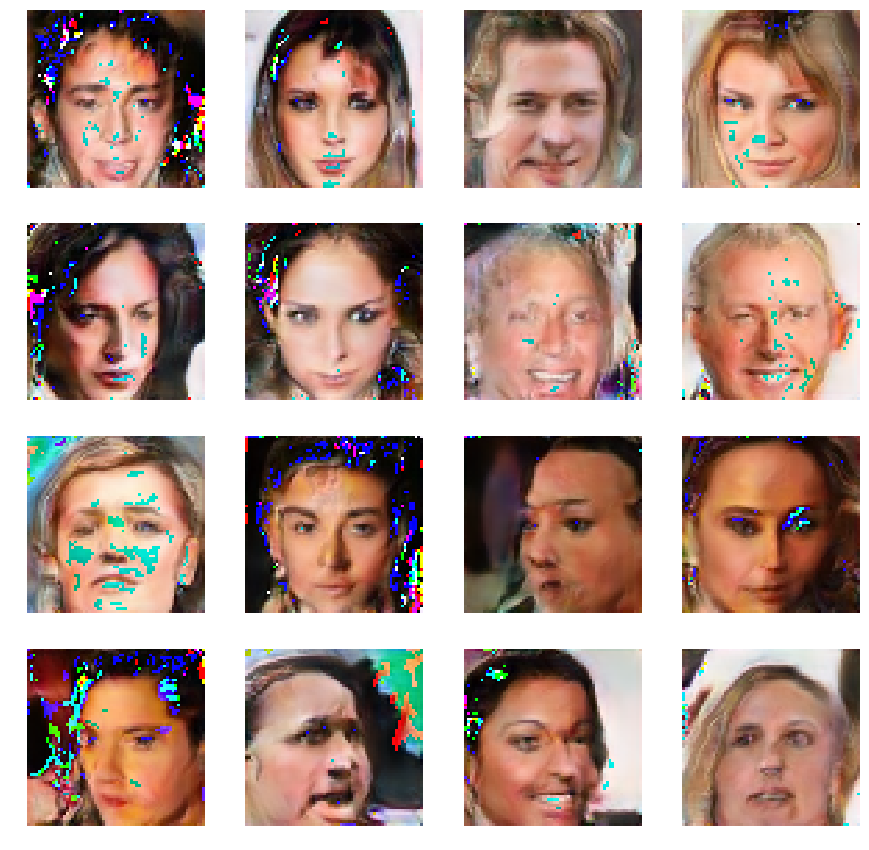

In [37]:
NOISE.data.normal_()
show((generator(NOISE, 6) + 1) / 2, 16, square=True)

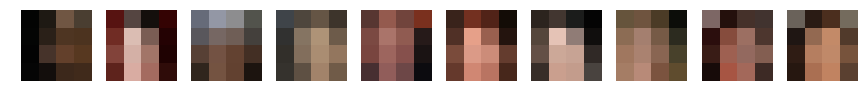

In [198]:
Rr = 2checkpoint({
                'R': R,
                'stage': stage,
                'gen': generator.state_dict(),
                'dis': discriminator.state_dict(),
                'optim_G': optim_G.state_dict(),
                'optim_D': optim_D.state_dict(),
                'n_iter': n_iter,
                'print_every': print_every,
                'max_R': max_R
            }, path='d
X = Variable(data_acc.get_next(), requires_grad=False).permute(0, 3, 1, 2).float()
X = nn.AvgPool2d(2**(7 - Rr))(X)
X = X.data.permute(0, 2, 3, 1).numpy()
plt.figure(figsize=(15, 7))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X[i].reshape(2**Rr, 2**Rr, 3))
    plt.axis('off')
plt.show()

In [23]:
def mean_L2(t):
    return torch.mean(t ** 2)

def print_generator_info(gen):
    print('=' * 10 + ' GENERATOR ' + '=' * 10)
    
    print('first_block_1: ' + str(mean_L2(gen.first_block[0].weight.data))
         + ' / grad: ' + str(mean_L2(gen.first_block[0].weight.grad.data)))
    print('first_block_2: ' + str(mean_L2(gen.first_block[3].weight.data))
         + ' / grad: ' + str(mean_L2(gen.first_block[3].weight.grad.data)))
    
    for i, c in enumerate(gen.to_rgb):
        print('to_rgb_' + str(i) + ': ' + str(mean_L2(c.weight.data))
             + ' / grad: ' + str(mean_L2(c.weight.grad.data)))
    
    for i, seq in enumerate(gen.iter_blocks):
        print('iter_blocks_' + str(i) + '_1: ' + str(mean_L2(seq[0].weight.data))
             + ' / grad: ' + str(mean_L2(seq[0].weight.grad.data)))
        print('iter_blocks_' + str(i) + '_2: ' + str(mean_L2(seq[3].weight.data))
             + ' / grad: ' + str(mean_L2(seq[3].weight.grad.data)))
        
def print_discriminator_info(dis):
    print('=' * 10 + ' DISCRIMINATOR ' + '=' * 10)
    
    for i, c in enumerate(dis.from_rgb):
        print('from_rgb_' + str(i) + ': ' + str(mean_L2(c[0].weight.data))
             + ' / grad: ' + str(mean_L2(c[0].weight.grad.data)))
        
    for i, seq in enumerate(dis.iter_blocks):
        print('iter_blocks_' + str(i) + '_1: ' + str(mean_L2(seq[0].weight.data))
             + ' / grad: ' + str(mean_L2(seq[0].weight.grad.data)))
        print('iter_blocks_' + str(i) + '_2: ' + str(mean_L2(seq[2].weight.data))
             + ' / grad: ' + str(mean_L2(seq[2].weight.grad.data)))
        
    print('final_conv_1: ' + str(mean_L2(dis.final_conv[0].weight.data))
         + ' / grad: ' + str(mean_L2(dis.final_conv[0].weight.grad.data)))
    print('final_conv_2: ' + str(mean_L2(dis.final_conv[2].weight.data))
         + ' / grad: ' + str(mean_L2(dis.final_conv[2].weight.grad.data)))
    
    print('pred: ' + str(mean_L2(dis.pred.weight.data))
         + ' / grad: ' + str(mean_L2(dis.pred.weight.grad.data)))
    
def print_gd_info(g, d):
    print_generator_info(g)
    print_discriminator_info(d)